In [50]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# Constants
class Filter:
    min_seq_len: int = 10
    max_seq_len: int = 200

class Experiment:
    filter = Filter()

In [38]:
exp = Experiment()

In [11]:
file_path = "/Users/deepak.dhull/data/recsys/ml-1m/ratings.dat"

In [12]:
ratings = pd.read_csv(file_path, delimiter='::', engine='python', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [14]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
def func(df: pd.DataFrame):
    item_seq = df.sort_values(by=['timestamp'], ascending=True)['movie_id'].tolist()
    rating_seq = df.sort_values(by=['timestamp'], ascending=True)['rating'].tolist()
    return item_seq, rating_seq

user_seq_df = ratings.groupby('user_id').apply(func)

In [21]:
user_seq_df = user_seq_df.reset_index().rename(columns={0: 'sequence'})

In [27]:
user_seq_df['seq_length'] = user_seq_df['sequence'].map(lambda x: len(x[0]))

In [41]:
user_seq_df.shape

(6040, 3)

In [43]:
filters = (user_seq_df['seq_length'] >= exp.filter.min_seq_len) & \
            (user_seq_df['seq_length'] <= exp.filter.max_seq_len)

In [45]:
user_seq_df = user_seq_df[filters]

In [51]:
user_seq_df.head()

,user_id,sequence,seq_length
0,1,"([3186, 1721, 1022, 1270, 2340, 1836, 3408, 12...",53
1,2,"([1198, 1217, 1210, 2717, 1293, 2943, 1225, 11...",129
2,3,"([593, 2858, 3534, 1968, 1961, 1431, 1266, 137...",51
3,4,"([1210, 1097, 3468, 3527, 480, 260, 1196, 1198...",21
4,5,"([2717, 919, 908, 356, 1250, 2188, 2858, 1127,...",198


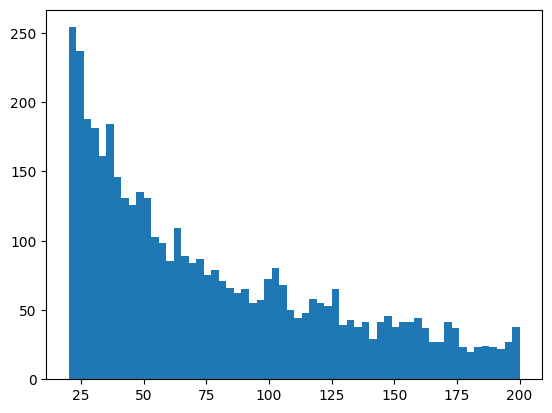

In [47]:
plt.hist(user_seq_df['seq_length'], bins=60)
plt.show()

In [52]:
class MovieDataset(Dataset):
    def __init__(self, config: Experiment, df: pd.DataFrame):
        self.df = df
        self.config = config
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        item_ids, ratings = row['sequence']
        seq_length = row['seq_length']
        item_ids = torch.tensor(item_ids)
        ratings = torch.tensor(ratings)
        _pad = max(0, self.config.filter.max_seq_len - seq_length)
        item_ids = F.pad(item_ids, pad=(0, _pad), value=0).to(torch.long)
        ratings = F.pad(ratings, pad=(0, _pad), value=0).to(torch.long)
        mask = (item_ids != 0).bool()

        return item_ids, ratings, mask

In [61]:
ds = MovieDataset(exp, user_seq_df)
inp = next(iter(ds))
inp[0][inp[2]]

tensor([3186, 1721, 1022, 1270, 2340, 1836, 3408, 1207, 2804,  720, 1193,  260,
         919,  608, 2692, 1961, 2028, 3105,  938, 1962, 1035,  150, 2018, 1028,
        1097,  914, 2797, 1287, 2762, 1246,  661, 2918,  531, 3114, 2791, 1029,
        2321, 1197,  594, 2398, 1545,  527,    1,  588, 2687,  745,  595, 2294,
         783, 2355, 1907, 1566,   48])

In [ ]:
class 